In [1]:
!pip install ultralytics opencv-python mediapipe torch torchvision pandas numpy scikit-learn matplotlib seaborn tqdm torch-geometric


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from ultralytics import YOLO
import mediapipe as mp
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using device: cpu
PyTorch version: 2.9.1
CUDA available: False


In [155]:
class Config:
    # Paths
    DATASET_PATH = 'Violence_Dataset'
    VIOLENCE_PATH = os.path.join(DATASET_PATH, 'Violence')
    NON_VIOLENCE_PATH = os.path.join(DATASET_PATH, 'NonViolence')
    OUTPUT_PATH = 'output_videos'
    MODEL_SAVE_PATH = 'models'
    
    # Video Processing
    FRAME_SAMPLE_RATE = 2
    SEQUENCE_LENGTH = 16
    IMG_SIZE = 320
    
    # Training Parameters
    BATCH_SIZE = 8
    EPOCHS = 100
    LEARNING_RATE = 0.0001
    PATIENCE = 15
    MIN_DELTA = 0.001
    
    # Model Parameters
    YOLO_MODEL = 'yolov8n.pt'  # YOLOv8 Nano (more accurate than nano)
    HIDDEN_SIZE = 256
    GNN_HIDDEN = 128
    GNN_LAYERS = 3
    LSTM_LAYERS = 2
    DROPOUT = 0.4
    
    # Regularization
    WEIGHT_DECAY = 1e-4
    LABEL_SMOOTHING = 0.1
    
    # Feature dimensions
    YOLO_FEATURE_DIM = 20  # Enhanced YOLO features
    KEYPOINT_FEATURE_DIM = 33 * 3  # 33 keypoints * 3 (x, y, visibility)
    KEYPOINT_COUNT = 33
    
config = Config()


print("\n" + "="*70)
print("CONFIGURATION - GNN + YOLOv8n + KEYPOINTS")
print("="*70)
print(f"Model Architecture: Graph Neural Network + LSTM")
print(f"YOLO Model: YOLOv8 Nano")
print(f"Keypoints: MediaPipe 33 pose landmarks")
print(f"Sequence Length: {config.SEQUENCE_LENGTH} frames")
print(f"GNN Hidden Size: {config.GNN_HIDDEN}")
print(f"GNN Layers: {config.GNN_LAYERS}")
print("="*70)


CONFIGURATION - GNN + YOLOv8n + KEYPOINTS
Model Architecture: Graph Neural Network + LSTM
YOLO Model: YOLOv8 Nano
Keypoints: MediaPipe 33 pose landmarks
Sequence Length: 16 frames
GNN Hidden Size: 128
GNN Layers: 3


In [91]:
POSE_CONNECTIONS = [
    # Face
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    # Upper body
    (9, 10), (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),
    # Torso
    (11, 23), (12, 24), (23, 24),
    # Lower body
    (23, 25), (25, 27), (27, 29), (27, 31), (29, 31),
    (24, 26), (26, 28), (28, 30), (28, 32), (30, 32)
]

print(f"✓ Pose skeleton defined: {len(POSE_CONNECTIONS)} connections")


✓ Pose skeleton defined: 33 connections


In [93]:
class HybridFeatureExtractor:
    """Extract YOLO + Keypoint features with graph structure"""
    
    def __init__(self, yolo_model_path):
        # Initialize YOLOv8 Nano
        print("Loading YOLOv8 Nano model...")
        self.yolo_model = YOLO(yolo_model_path)
        print("✓ YOLOv8n model loaded")
        
        # Initialize MediaPipe Pose
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            smooth_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        print("✓ MediaPipe Pose loaded")
        
        self.yolo_feature_dim = config.YOLO_FEATURE_DIM
        self.keypoint_feature_dim = config.KEYPOINT_FEATURE_DIM
        
    def extract_yolo_features(self, frame):
        """Extract enhanced YOLO object detection features"""
        results = self.yolo_model(frame, verbose=False)[0]
        features = np.zeros(self.yolo_feature_dim)
        
        if results.boxes is not None and len(results.boxes) > 0:
            boxes = results.boxes.cpu().numpy()
            
            person_boxes = []
            weapon_boxes = []
            object_boxes = []
            all_confidences = []
            all_areas = []
            
            for box in boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                x1, y1, x2, y2 = box.xyxy[0]
                
                width = x2 - x1
                height = y2 - y1
                area = width * height
                aspect_ratio = width / (height + 1e-6)
                center_x = (x1 + x2) / 2 / frame.shape[1]  # Normalized
                center_y = (y1 + y2) / 2 / frame.shape[0]  # Normalized
                
                class_name = results.names[cls_id]
                all_confidences.append(conf)
                all_areas.append(area)
                
                if class_name == 'person':
                    person_boxes.append({
                        'bbox': [x1, y1, x2, y2],
                        'conf': conf,
                        'center': [center_x, center_y],
                        'area': area,
                        'aspect_ratio': aspect_ratio
                    })
                elif class_name in ['knife', 'baseball bat', 'scissors', 'bottle', 'sports ball']:
                    weapon_boxes.append({
                        'bbox': [x1, y1, x2, y2],
                        'conf': conf,
                        'center': [center_x, center_y],
                        'area': area
                    })
                else:
                    object_boxes.append({'conf': conf, 'area': area})
            
            # Feature 0-4: Person statistics
            features[0] = len(person_boxes)
            features[1] = np.mean([p['conf'] for p in person_boxes]) if person_boxes else 0
            features[2] = np.max([p['area'] for p in person_boxes]) if person_boxes else 0
            features[3] = np.std([p['area'] for p in person_boxes]) if len(person_boxes) > 1 else 0
            features[4] = np.mean([p['aspect_ratio'] for p in person_boxes]) if person_boxes else 0
            
            # Feature 5-8: Weapon statistics
            features[5] = len(weapon_boxes)
            features[6] = np.mean([w['conf'] for w in weapon_boxes]) if weapon_boxes else 0
            features[7] = 1 if weapon_boxes else 0
            features[8] = np.max([w['area'] for w in weapon_boxes]) if weapon_boxes else 0
            
            # Feature 9-11: Person-weapon interactions
            if person_boxes and weapon_boxes:
                min_dist = float('inf')
                for person in person_boxes:
                    for weapon in weapon_boxes:
                        dist = np.sqrt((person['center'][0] - weapon['center'][0])**2 + 
                                     (person['center'][1] - weapon['center'][1])**2)
                        min_dist = min(min_dist, dist)
                features[9] = 1.0 / (min_dist + 1e-6)
                features[10] = 1
                features[11] = len(person_boxes) * len(weapon_boxes)  # Interaction count
            
            # Feature 12-14: Spatial distribution
            if person_boxes:
                centers_x = [p['center'][0] for p in person_boxes]
                centers_y = [p['center'][1] for p in person_boxes]
                features[12] = np.std(centers_x) if len(centers_x) > 1 else 0
                features[13] = np.std(centers_y) if len(centers_y) > 1 else 0
                features[14] = np.mean(centers_x)  # Average x position
            
            # Feature 15-19: Overall scene statistics
            features[15] = len(all_confidences)
            features[16] = np.mean(all_confidences) if all_confidences else 0
            features[17] = np.sum(all_areas) / (frame.shape[0] * frame.shape[1]) if all_areas else 0
            features[18] = np.max(all_confidences) if all_confidences else 0
            features[19] = len(object_boxes)  # Other objects count
        
        return features
    
    def extract_keypoint_graph(self, frame):
        """Extract MediaPipe keypoints as graph structure"""
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.pose.process(frame_rgb)
        
        # Node features (33 keypoints with x, y, visibility, velocity)
        node_features = np.zeros((config.KEYPOINT_COUNT, 4))
        
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            for idx, landmark in enumerate(landmarks):
                node_features[idx, 0] = landmark.x
                node_features[idx, 1] = landmark.y
                node_features[idx, 2] = landmark.visibility
                node_features[idx, 3] = landmark.z if hasattr(landmark, 'z') else 0
        
        # Edge indices based on human skeleton
        edge_index = torch.tensor(POSE_CONNECTIONS, dtype=torch.long).t().contiguous()
        
        # Create graph data
        graph_data = Data(
            x=torch.FloatTensor(node_features),
            edge_index=edge_index
        )
        
        return graph_data, node_features.flatten()
    
    def extract_frame_features(self, frame):
        """Extract complete features: YOLO + Keypoint graph"""
        yolo_features = self.extract_yolo_features(frame)
        graph_data, keypoint_features = self.extract_keypoint_graph(frame)
        
        return {
            'yolo': yolo_features,
            'graph': graph_data,
            'keypoints': keypoint_features
        }
    
    def extract_sequence_from_video(self, video_path):
        """Extract feature sequences from video"""
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {video_path}")
        
        sequences = []
        frame_count = 0
        
        yolo_buffer = []
        graph_buffer = []
        keypoint_buffer = []
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count % config.FRAME_SAMPLE_RATE == 0:
                frame_resized = cv2.resize(frame, (config.IMG_SIZE, config.IMG_SIZE))
                features = self.extract_frame_features(frame_resized)
                
                yolo_buffer.append(features['yolo'])
                graph_buffer.append(features['graph'])
                keypoint_buffer.append(features['keypoints'])
                
                if len(yolo_buffer) == config.SEQUENCE_LENGTH:
                    sequences.append({
                        'yolo': np.array(yolo_buffer),
                        'graphs': graph_buffer.copy(),
                        'keypoints': np.array(keypoint_buffer)
                    })
                    yolo_buffer.pop(0)
                    graph_buffer.pop(0)
                    keypoint_buffer.pop(0)
            
            frame_count += 1
        
        cap.release()
        
        # Handle short videos
        if len(yolo_buffer) > 0 and len(sequences) == 0:
            while len(yolo_buffer) < config.SEQUENCE_LENGTH:
                yolo_buffer.append(np.zeros(config.YOLO_FEATURE_DIM))
                
                empty_graph = Data(
                    x=torch.zeros((config.KEYPOINT_COUNT, 4)),
                    edge_index=torch.tensor(POSE_CONNECTIONS, dtype=torch.long).t().contiguous()
                )
                graph_buffer.append(empty_graph)
                keypoint_buffer.append(np.zeros(config.KEYPOINT_FEATURE_DIM))
            
            sequences.append({
                'yolo': np.array(yolo_buffer),
                'graphs': graph_buffer,
                'keypoints': np.array(keypoint_buffer)
            })
        
        return sequences


In [95]:
def prepare_dataset(violence_path, non_violence_path, extractor):
    """Prepare dataset with GNN features"""
    data = []
    
    print("\n" + "="*70)
    print("PREPARING DATASET WITH GNN FEATURES")
    print("="*70)
    
    # Process violence videos
    print("\n[1/2] Processing VIOLENCE videos...")
    violence_videos = list(Path(violence_path).glob('*.mp4')) + \
                     list(Path(violence_path).glob('*.avi')) + \
                     list(Path(violence_path).glob('*.mov'))
    
    if len(violence_videos) == 0:
        print("⚠ WARNING: No violence videos found!")
    
    for video_path in tqdm(violence_videos, desc="Violence videos"):
        try:
            sequences = extractor.extract_sequence_from_video(str(video_path))
            for seq in sequences:
                data.append({
                    'yolo_sequence': seq['yolo'],
                    'graph_sequence': seq['graphs'],
                    'keypoint_sequence': seq['keypoints'],
                    'label': 1,
                    'video_path': str(video_path)
                })
        except Exception as e:
            print(f"✗ Error processing {video_path.name}: {e}")
    
    # Process non-violence videos
    print("\n[2/2] Processing NON-VIOLENCE videos...")
    non_violence_videos = list(Path(non_violence_path).glob('*.mp4')) + \
                         list(Path(non_violence_path).glob('*.avi')) + \
                         list(Path(non_violence_path).glob('*.mov'))
    
    if len(non_violence_videos) == 0:
        print("⚠ WARNING: No non-violence videos found!")
    
    for video_path in tqdm(non_violence_videos, desc="Non-violence videos"):
        try:
            sequences = extractor.extract_sequence_from_video(str(video_path))
            for seq in sequences:
                data.append({
                    'yolo_sequence': seq['yolo'],
                    'graph_sequence': seq['graphs'],
                    'keypoint_sequence': seq['keypoints'],
                    'label': 0,
                    'video_path': str(video_path)
                })
        except Exception as e:
            print(f"✗ Error processing {video_path.name}: {e}")
    
    print("\n" + "="*70)
    print("DATASET SUMMARY")
    print("="*70)
    print(f"Total sequences: {len(data)}")
    print(f"Violence sequences: {sum([1 for d in data if d['label'] == 1])}")
    print(f"Non-violence sequences: {sum([1 for d in data if d['label'] == 0])}")
    print(f"YOLO features per frame: {config.YOLO_FEATURE_DIM}")
    print(f"Graph nodes per frame: {config.KEYPOINT_COUNT}")
    print(f"Sequence length: {config.SEQUENCE_LENGTH} frames")
    print("="*70)
    
    return data


In [97]:
class ViolenceDataset(Dataset):
    """Dataset with data augmentation"""
    
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]['sequence'].copy()
        label = self.data[idx]['label']
        
        # Data augmentation for training
        if self.augment:
            # Add small Gaussian noise
            if np.random.random() > 0.5:
                noise = np.random.normal(0, 0.01, sequence.shape)
                sequence = sequence + noise
            
            # Random temporal shift
            if np.random.random() > 0.5:
                shift = np.random.randint(-2, 3)
                sequence = np.roll(sequence, shift, axis=0)
            
            # Random feature scaling
            if np.random.random() > 0.5:
                scale = np.random.uniform(0.95, 1.05)
                sequence = sequence * scale
        
        return torch.FloatTensor(sequence), torch.LongTensor([label])


In [99]:

class GNNViolenceDataset(Dataset):
    """Dataset with graph data"""
    
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        yolo_seq = self.data[idx]['yolo_sequence'].copy()
        graph_seq = self.data[idx]['graph_sequence']
        keypoint_seq = self.data[idx]['keypoint_sequence'].copy()
        label = self.data[idx]['label']
        
        # Data augmentation
        if self.augment:
            if np.random.random() > 0.5:
                noise = np.random.normal(0, 0.01, yolo_seq.shape)
                yolo_seq = yolo_seq + noise
            
            if np.random.random() > 0.5:
                shift = np.random.randint(-2, 3)
                yolo_seq = np.roll(yolo_seq, shift, axis=0)
                keypoint_seq = np.roll(keypoint_seq, shift, axis=0)
        
        return {
            'yolo': torch.FloatTensor(yolo_seq),
            'graphs': graph_seq,
            'keypoints': torch.FloatTensor(keypoint_seq),
            'label': torch.LongTensor([label])
        }

def collate_fn(batch):
    """Custom collate function for batching graph data"""
    yolo_batch = torch.stack([item['yolo'] for item in batch])
    keypoint_batch = torch.stack([item['keypoints'] for item in batch])
    label_batch = torch.stack([item['label'] for item in batch])
    
    # Flatten graphs for batching
    all_graphs = []
    for item in batch:
        all_graphs.extend(item['graphs'])
    
    graph_batch = Batch.from_data_list(all_graphs)
    
    return {
        'yolo': yolo_batch,
        'graphs': graph_batch,
        'keypoints': keypoint_batch,
        'labels': label_batch
    }


In [101]:
class PoseGNN(nn.Module):
    """Graph Neural Network for pose keypoint analysis"""
    
    def __init__(self, input_dim=4, hidden_dim=128, num_layers=3, dropout=0.4):
        super(PoseGNN, self).__init__()
        
        self.num_layers = num_layers
        
        # Graph Attention Convolution layers
        self.convs = nn.ModuleList()
        self.convs.append(GATConv(input_dim, hidden_dim, heads=4, dropout=dropout))
        
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_dim * 4, hidden_dim, heads=4, dropout=dropout))
        
        self.convs.append(GATConv(hidden_dim * 4, hidden_dim, heads=1, dropout=dropout))
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim * 4) for _ in range(num_layers - 1)])
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
    def forward(self, x, edge_index, batch):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        return x


In [103]:
class GNNViolenceDetectionModel(nn.Module):
    """Hybrid model: GNN + YOLO + LSTM"""
    
    def __init__(self, yolo_dim, keypoint_dim, hidden_size=256, gnn_hidden=128, 
                 gnn_layers=3, lstm_layers=2, dropout=0.4):
        super(GNNViolenceDetectionModel, self).__init__()
        
        # GNN for pose graphs
        self.gnn = PoseGNN(input_dim=4, hidden_dim=gnn_hidden, num_layers=gnn_layers, dropout=dropout)
        
        # Feature fusion
        self.yolo_projection = nn.Linear(yolo_dim, hidden_size // 2)
        self.gnn_projection = nn.Linear(gnn_hidden, hidden_size // 2)
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention
        self.attention = nn.Linear(hidden_size * 2, 1)
        
        # Classification head
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout / 2)
        
        self.fc4 = nn.Linear(64, 2)
        
        self.relu = nn.ReLU()
        
    def forward(self, yolo_features, graph_batch, batch_size, seq_len):
        # Process graphs through GNN
        gnn_output = self.gnn(graph_batch.x, graph_batch.edge_index, graph_batch.batch)
        gnn_output = gnn_output.view(batch_size, seq_len, -1)
        
        # Project features
        yolo_proj = self.relu(self.yolo_projection(yolo_features))
        gnn_proj = self.relu(self.gnn_projection(gnn_output))
        
        # Fuse features
        fused = torch.cat([yolo_proj, gnn_proj], dim=-1)
        
        # LSTM processing
        lstm_out, _ = self.lstm(fused)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Classification
        x = self.relu(self.bn1(self.fc1(context)))
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        
        return x, attention_weights


In [127]:
def train_model(model, train_loader, val_loader, num_epochs):
    """Train the GNN model"""
    
    criterion = nn.CrossEntropyLoss(label_smoothing=config.LABEL_SMOOTHING)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'learning_rates': []
    }
    
    best_val_loss = float('inf')
    best_val_acc = 0
    best_f1 = 0
    patience_counter = 0
    best_model_state = None
    
    print("\n" + "="*70)
    print("TRAINING GNN MODEL")
    print("="*70)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
        for batch in train_bar:
            yolo = batch['yolo'].to(device)
            graphs = batch['graphs'].to(device)
            labels = batch['labels'].to(device).squeeze()
            
            batch_size = yolo.size(0)
            seq_len = yolo.size(1)
            
            optimizer.zero_grad()
            outputs, _ = model(yolo, graphs, batch_size, seq_len)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds) * 100
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
            for batch in val_bar:
                yolo = batch['yolo'].to(device)
                graphs = batch['graphs'].to(device)
                labels = batch['labels'].to(device).squeeze()
                
                batch_size = yolo.size(0)
                seq_len = yolo.size(1)
                
                outputs, _ = model(yolo, graphs, batch_size, seq_len)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        scheduler.step(avg_val_loss)
        
        print("\n" + "-"*70)
        print(f"EPOCH {epoch+1}/{num_epochs} SUMMARY")
        print("-"*70)
        print(f"Train - Loss: {avg_train_loss:.4f} | Acc: {train_acc:.2f}% | F1: {train_f1:.4f}")
        print(f"Val   - Loss: {avg_val_loss:.4f} | Acc: {val_acc:.2f}% | F1: {val_f1:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        improved = False
        if avg_val_loss < (best_val_loss - config.MIN_DELTA):
            best_val_loss = avg_val_loss
            improved = True
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            improved = True
        if val_f1 > best_f1:
            best_f1 = val_f1
            improved = True
        
        if improved:
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"✓ MODEL IMPROVED! (Val Acc: {val_acc:.2f}%, F1: {val_f1:.4f})")
        else:
            patience_counter += 1
            print(f"✗ No improvement. Patience: {patience_counter}/{config.PATIENCE}")
        
        print("-"*70)
        
        if patience_counter >= config.PATIENCE:
            print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model - Val Acc: {best_val_acc:.2f}%, F1: {best_f1:.4f}")
    
    return model, history


In [107]:
def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("\n" + "="*70)
    print("MODEL EVALUATION")
    print("="*70)
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            yolo = batch['yolo'].to(device)
            graphs = batch['graphs'].to(device)
            labels = batch['labels'].to(device).squeeze()
            
            batch_size = yolo.size(0)
            seq_len = yolo.size(1)
            
            outputs, _ = model(yolo, graphs, batch_size, seq_len)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_probs = np.array(all_probs)
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    try:
        auc = roc_auc_score(all_labels, all_probs[:, 1])
    except:
        auc = 0.0
    
    print("\n" + "="*70)
    print("TEST SET RESULTS")
    print("="*70)
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    if auc > 0:
        print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['Non-Violence', 'Violence'],
                                digits=4))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Violence', 'Violence'],
                yticklabels=['Non-Violence', 'Violence'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return all_preds, all_labels, all_probs



In [109]:
def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
    axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2, markersize=6)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-s', label='Val Accuracy', linewidth=2, markersize=6)
    axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 0].plot(epochs, history['train_f1'], 'b-o', label='Train F1', linewidth=2, markersize=6)
    axes[1, 0].plot(epochs, history['val_f1'], 'r-s', label='Val F1', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Training and Validation F1 Score', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Overfitting Analysis
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1, 1].plot(epochs, train_val_gap, 'r-o', linewidth=2, markersize=6, label='Accuracy Gap')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(y=5, color='orange', linestyle='--', alpha=0.5, label='±5% threshold')
    axes[1, 1].axhline(y=-5, color='orange', linestyle='--', alpha=0.5)
    axes[1, 1].fill_between(epochs, train_val_gap, 0, alpha=0.3, color='red')
    axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Accuracy Gap (%)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Overfitting Analysis (Train - Val)', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Learning rate plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['learning_rates'], 'g-o', linewidth=2, markersize=6)
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Learning Rate', fontsize=12, fontweight='bold')
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


In [318]:
def predict_video_frame_by_frame(video_path, model, extractor, output_path=None, show_frames=True):
    """
    Predict violence with FRAME-BY-FRAME probability using GNN model
    """

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"✗ Error: Cannot open video {video_path}")
        return None

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # FRAME SKIP SETTINGS
    skip_frames = 4
    frame_id = 0

    print("\n" + "=" * 70)
    print("VIDEO PREDICTION - FRAME BY FRAME (GNN MODEL)")
    print("=" * 70)
    print(f"Video: {video_path}")
    print(f"Total Frames: {total_frames}")
    print(f"FPS: {fps}")
    print(f"Resolution: {width}x{height}")
    print("=" * 70 + "\n")

    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    model.eval()

    yolo_buffer = deque(maxlen=config.SEQUENCE_LENGTH)
    graph_buffer = deque(maxlen=config.SEQUENCE_LENGTH)
    frame_results = []
    display_frames = []

    frame_count = 0

    with tqdm(total=total_frames, desc="Processing video") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # FRAME SKIPPING LOGIC
            if frame_id % skip_frames != 0:
                frame_id += 1
                pbar.update(1)
                continue

            # Resize frame
            frame_resized = cv2.resize(frame, (config.IMG_SIZE, config.IMG_SIZE))

            # Extract features
            features = extractor.extract_frame_features(frame_resized)

            yolo_buffer.append(features['yolo'])
            graph_buffer.append(features['graph'])

            violence_prob = 0.0
            non_violence_prob = 0.0
            prediction = 0

            # Only predict once buffers are filled
            if len(yolo_buffer) == config.SEQUENCE_LENGTH:
                yolo_seq = torch.FloatTensor(np.array(list(yolo_buffer))).unsqueeze(0).to(device)
                graph_list = list(graph_buffer)
                graph_batch = Batch.from_data_list(graph_list).to(device)

                with torch.no_grad():
                    output, attention = model(yolo_seq, graph_batch, 1, config.SEQUENCE_LENGTH)
                    probs = torch.softmax(output, dim=1)
                    violence_prob = probs[0][1].item()
                    non_violence_prob = probs[0][0].item()
                    prediction = 1 if violence_prob > 0.5 else 0

            # Save frame result
            frame_results.append({
                'frame': frame_count,
                'violence_prob': violence_prob,
                'non_violence_prob': non_violence_prob,
                'prediction': prediction
            })

            # Annotate frame
            annotated_frame = frame.copy()

            # overlay = annotated_frame.copy()
            # cv2.rectangle(overlay, (10, 10), (width - 10, 220), (0, 0, 0), -1)
            # cv2.addWeighted(overlay, 0.7, annotated_frame, 0.3, 0, annotated_frame)

            cv2.putText(annotated_frame, f"Frame: {frame_count + 1}/{total_frames}",
                        (20, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

            label = "VIOLENCE DETECTED" if prediction == 1 else "NON-VIOLENCE"
            label_color = (0, 0, 255) if prediction == 1 else (0, 255, 0)
            cv2.putText(annotated_frame, f"Prediction: {label}",
                        (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.0, label_color, 3)

            cv2.putText(annotated_frame, f"Violence Prob: {violence_prob:.4f}",
                        (20, 135), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 2)

            cv2.putText(annotated_frame, f"Non-Violence Prob: {non_violence_prob:.4f}",
                        (20, 175), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 255, 0), 2)

            confidence = max(violence_prob, non_violence_prob) * 100
            cv2.putText(annotated_frame, f"Confidence: {confidence:.2f}%",
                        (20, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)

            if output_path:
                out.write(annotated_frame)

            if show_frames and frame_count % 30 == 0:
                display_frames.append((frame_count, annotated_frame))

            frame_count += 1
            frame_id += 1
            pbar.update(1)

    cap.release()
    if output_path:
        out.release()
        print(f"\n✓ Output video saved: {output_path}")

    # Display sample frames
    if show_frames and display_frames:
        n_display = min(6, len(display_frames))
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for idx, (frame_num, frame) in enumerate(display_frames[:n_display]):
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(frame_rgb)
            axes[idx].axis('off')
            result = frame_results[frame_num]
            axes[idx].set_title(f"Frame {result['frame']+1}: {'Violence' if result['prediction']==1 else 'Non-Violence'}\n"
                              f"Prob: {result['violence_prob']:.4f}", 
                              fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Probability plot
    frames = [r['frame'] for r in frame_results]
    violence_probs = [r['violence_prob'] for r in frame_results]
    
    plt.figure(figsize=(16, 6))
    plt.plot(frames, violence_probs, linewidth=2, color='red', label='Violence Probability')
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Decision Threshold') 
    plt.fill_between(frames, violence_probs, 0.5, 
                     where=[v > 0.5 for v in violence_probs], 
                     color='red', alpha=0.3, label='Violence Detected')
    plt.fill_between(frames, violence_probs, 0.5, 
                     where=[v <= 0.5 for v in violence_probs], 
                     color='green', alpha=0.3, label='Non-Violence')
    plt.xlabel('Frame Number', fontsize=12, fontweight='bold')
    plt.ylabel('Violence Probability', fontsize=12, fontweight='bold')
    plt.title('Frame-by-Frame Violence Probability Over Time (GNN Model)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*70)
    print("PREDICTION SUMMARY")
    print("="*70)
    total_violence_frames = sum([1 for r in frame_results if r['prediction'] == 1])
    avg_violence_prob = np.mean([r['violence_prob'] for r in frame_results])
    max_violence_prob = np.max([r['violence_prob'] for r in frame_results])
    max_non_violence_prob = np.max([r['non_violence_prob'] for r in frame_results]) 
    
    print(f"Total Frames Processed: {len(frame_results)}")
    print(f"Violence Frames: {total_violence_frames} ({total_violence_frames/len(frame_results)*100:.2f}%)")
    print(f"Non-Violence Frames: {len(frame_results)-total_violence_frames} ({(len(frame_results)-total_violence_frames)/len(frame_results)*100:.2f}%)")
    # print(f"Average Violence Probability: {avg_violence_prob:.4f}")
    print(f"Maximum Violence Probability: {max_violence_prob:.4f}")
    print(f"Maximum Non Violence Probability: {max_non_violence_prob:.4f}") 
    #print(f"Overall Video Prediction: {'VIOLENCE' if total_violence_frames/len(frame_results) > 0.5 else 'NON-VIOLENCE'}")
    overall_prediction = "VIOLENCE" if max_violence_prob > max_non_violence_prob else "NON-VIOLENCE"
    print(f"Overall Video Prediction: {overall_prediction}")

    print("="*70)
    
    return frame_results


In [157]:
def save_model(model, history, filepath):
    """Save complete GNN model checkpoint"""
    # Get directory path
    dir_path = os.path.dirname(filepath)
    
    # Only create directory if there is a directory component
    if dir_path and dir_path != '':
        os.makedirs(dir_path, exist_ok=True)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': {
            'yolo_dim': config.YOLO_FEATURE_DIM,
            'keypoint_dim': config.KEYPOINT_FEATURE_DIM,
            'hidden_size': config.HIDDEN_SIZE,
            'gnn_hidden': config.GNN_HIDDEN,
            'gnn_layers': config.GNN_LAYERS,
            'lstm_layers': config.LSTM_LAYERS,
            'dropout': config.DROPOUT,
            'sequence_length': config.SEQUENCE_LENGTH
        },
        'history': history
    }, filepath)
    print(f"\n✓ GNN Model saved to: {filepath}")

In [115]:
def load_model(filepath):
    """Load saved GNN model"""
    checkpoint = torch.load(filepath, map_location=device)
    
    model = GNNViolenceDetectionModel(
        yolo_dim=checkpoint['config']['yolo_dim'],
        keypoint_dim=checkpoint['config']['keypoint_dim'],
        hidden_size=checkpoint['config']['hidden_size'],
        gnn_hidden=checkpoint['config']['gnn_hidden'],
        gnn_layers=checkpoint['config']['gnn_layers'],
        lstm_layers=checkpoint['config']['lstm_layers'],
        dropout=checkpoint['config']['dropout']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ GNN Model loaded from: {filepath}")
    return model, checkpoint['history']


In [117]:
print("\n" + "="*70)
print("INITIALIZING GNN + YOLOv8n + KEYPOINTS EXTRACTOR")
print("="*70)

extractor = HybridFeatureExtractor(config.YOLO_MODEL)

print("\n✓ Hybrid Feature Extractor Ready!")
print(f"  - YOLO Model: YOLOv8 Nano")
print(f"  - YOLO Features: {config.YOLO_FEATURE_DIM} dimensions")
print(f"  - Keypoint Nodes: {config.KEYPOINT_COUNT} (33 body landmarks)")
print(f"  - Graph Edges: {len(POSE_CONNECTIONS)} connections")
print(f"  - GNN Layers: {config.GNN_LAYERS}")



INITIALIZING GNN + YOLOv8n + KEYPOINTS EXTRACTOR
Loading YOLOv8 Nano model...
✓ YOLOv8n model loaded
✓ MediaPipe Pose loaded

✓ Hybrid Feature Extractor Ready!
  - YOLO Model: YOLOv8 Nano
  - YOLO Features: 20 dimensions
  - Keypoint Nodes: 33 (33 body landmarks)
  - Graph Edges: 33 connections
  - GNN Layers: 3


I0000 00:00:1763504267.424838 5933986 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2


In [119]:
dataset = prepare_dataset(config.VIOLENCE_PATH, config.NON_VIOLENCE_PATH, extractor)

if len(dataset) == 0:
    print("\n⚠ ERROR: No data found! Please add videos to:")
    print(f"  Violence: {config.VIOLENCE_PATH}")
    print(f"  Non-violence: {config.NON_VIOLENCE_PATH}")
    raise ValueError("Dataset is empty!")



PREPARING DATASET WITH GNN FEATURES

[1/2] Processing VIOLENCE videos...


Violence videos: 100%|████████████████████| 1000/1000 [3:35:07<00:00, 12.91s/it]



[2/2] Processing NON-VIOLENCE videos...


Non-violence videos:  86%|██████████████▋  | 863/1000 [2:45:35<05:31,  2.42s/it][h264 @ 0x4245c3e50] mb_type 104 in P slice too large at 98 31
[h264 @ 0x4245c3e50] error while decoding MB 98 31
Non-violence videos:  87%|██████████████▊  | 873/1000 [2:46:22<07:54,  3.74s/it]

✗ Error processing NV_940.mp4: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.


Non-violence videos: 100%|████████████████| 1000/1000 [2:57:55<00:00, 10.68s/it]


DATASET SUMMARY
Total sequences: 114335
Violence sequences: 65158
Non-violence sequences: 49177
YOLO features per frame: 20
Graph nodes per frame: 33
Sequence length: 16 frames


In [134]:
print("\n" + "="*70)
print("DATASET TOO LARGE - REDUCING SIZE")
print("="*70)

# Original size
print(f"Original dataset: {len(dataset)} sequences")

# Reduce to manageable size (10,000 sequences)
import random
random.seed(42)

# Separate by label
violence_data = [d for d in dataset if d['label'] == 1]
non_violence_data = [d for d in dataset if d['label'] == 0]

print(f"Original violence: {len(violence_data)}")
print(f"Original non-violence: {len(non_violence_data)}")

# Sample 5000 from each class
n_samples_per_class = 5000

violence_sampled = random.sample(violence_data, min(n_samples_per_class, len(violence_data)))
non_violence_sampled = random.sample(non_violence_data, min(n_samples_per_class, len(non_violence_data)))

# Combine
dataset = violence_sampled + non_violence_sampled
random.shuffle(dataset)

print(f"\n✓ Reduced dataset: {len(dataset)} sequences")
print(f"  - Violence: {sum([1 for d in dataset if d['label']==1])}")
print(f"  - Non-violence: {sum([1 for d in dataset if d['label']==0])}")
print("="*70)



DATASET TOO LARGE - REDUCING SIZE
Original dataset: 114335 sequences
Original violence: 65158
Original non-violence: 49177

✓ Reduced dataset: 10000 sequences
  - Violence: 5000
  - Non-violence: 5000


In [136]:
print("\n" + "="*70)
print("SPLITTING DATASET")
print("="*70)

labels = [d['label'] for d in dataset]
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42, stratify=labels)
temp_labels = [d['label'] for d in temp_data]
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_labels)

print(f"Train set: {len(train_data)} sequences")
print(f"  - Violence: {sum([1 for d in train_data if d['label']==1])}")
print(f"  - Non-violence: {sum([1 for d in train_data if d['label']==0])}")
print(f"\nValidation set: {len(val_data)} sequences")
print(f"  - Violence: {sum([1 for d in val_data if d['label']==1])}")
print(f"  - Non-violence: {sum([1 for d in val_data if d['label']==0])}")
print(f"\nTest set: {len(test_data)} sequences")
print(f"  - Violence: {sum([1 for d in test_data if d['label']==1])}")
print(f"  - Non-violence: {sum([1 for d in test_data if d['label']==0])}")

print(f"\n[1/3] Creating train dataset with {len(train_data)} sequences...")
train_dataset = GNNViolenceDataset(train_data, augment=True)
print("✓ Train dataset created")

print(f"\n[2/3] Creating validation dataset with {len(val_data)} sequences...")
val_dataset = GNNViolenceDataset(val_data, augment=False)
print("✓ Validation dataset created")

print(f"\n[3/3] Creating test dataset with {len(test_data)} sequences...")
test_dataset = GNNViolenceDataset(test_data, augment=False)
print("✓ Test dataset created")

print("\nCreating data loaders...")
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f"\n✓ Data loaders created (Batch size: {config.BATCH_SIZE})")


SPLITTING DATASET
Train set: 7000 sequences
  - Violence: 3500
  - Non-violence: 3500

Validation set: 1500 sequences
  - Violence: 750
  - Non-violence: 750

Test set: 1500 sequences
  - Violence: 750
  - Non-violence: 750

[1/3] Creating train dataset with 7000 sequences...
✓ Train dataset created

[2/3] Creating validation dataset with 1500 sequences...
✓ Validation dataset created

[3/3] Creating test dataset with 1500 sequences...
✓ Test dataset created

Creating data loaders...

✓ Data loaders created (Batch size: 8)


In [138]:
print("\n" + "="*70)
print("INITIALIZING GNN MODEL")
print("="*70)

model = GNNViolenceDetectionModel(
    yolo_dim=config.YOLO_FEATURE_DIM,
    keypoint_dim=config.KEYPOINT_FEATURE_DIM,
    hidden_size=config.HIDDEN_SIZE,
    gnn_hidden=config.GNN_HIDDEN,
    gnn_layers=config.GNN_LAYERS,
    lstm_layers=config.LSTM_LAYERS,
    dropout=config.DROPOUT
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ GNN Model initialized")
print(f"  - Architecture: GNN + LSTM + Attention")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Device: {device}")



INITIALIZING GNN MODEL
✓ GNN Model initialized
  - Architecture: GNN + LSTM + Attention
  - Total parameters: 3,158,339
  - Trainable parameters: 3,158,339
  - Device: cpu


In [140]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

model, history = train_model(model, train_loader, val_loader, config.EPOCHS)

print("\n✓ Training completed!")



STARTING TRAINING

TRAINING GNN MODEL


Epoch 1/100 [VAL]: 100%|█████████| 188/188 [00:06<00:00, 27.11it/s, loss=0.8673]



----------------------------------------------------------------------
EPOCH 1/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6751 | Acc: 58.61% | F1: 0.5851
Val   - Loss: 0.6778 | Acc: 60.00% | F1: 0.5429
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 60.00%, F1: 0.5429)
----------------------------------------------------------------------


Epoch 2/100 [VAL]: 100%|█████████| 188/188 [00:06<00:00, 31.07it/s, loss=0.8047]



----------------------------------------------------------------------
EPOCH 2/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6672 | Acc: 60.80% | F1: 0.6063
Val   - Loss: 0.6511 | Acc: 62.13% | F1: 0.5968
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 62.13%, F1: 0.5968)
----------------------------------------------------------------------


Epoch 3/100 [VAL]: 100%|█████████| 188/188 [00:05<00:00, 32.13it/s, loss=0.6089]



----------------------------------------------------------------------
EPOCH 3/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6629 | Acc: 61.60% | F1: 0.6159
Val   - Loss: 0.6361 | Acc: 63.80% | F1: 0.6379
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 63.80%, F1: 0.6379)
----------------------------------------------------------------------


Epoch 4/100 [VAL]: 100%|█████████| 188/188 [00:06<00:00, 30.89it/s, loss=0.5821]



----------------------------------------------------------------------
EPOCH 4/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6557 | Acc: 63.01% | F1: 0.6294
Val   - Loss: 0.6247 | Acc: 64.87% | F1: 0.6487
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 64.87%, F1: 0.6487)
----------------------------------------------------------------------


Epoch 5/100 [VAL]: 100%|█████████| 188/188 [00:05<00:00, 32.62it/s, loss=0.6313]



----------------------------------------------------------------------
EPOCH 5/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6522 | Acc: 62.89% | F1: 0.6284
Val   - Loss: 0.6303 | Acc: 62.20% | F1: 0.6219
Learning Rate: 0.000100
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 6/100 [VAL]: 100%|█████████| 188/188 [00:05<00:00, 32.33it/s, loss=0.5950]



----------------------------------------------------------------------
EPOCH 6/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6496 | Acc: 62.96% | F1: 0.6292
Val   - Loss: 0.6402 | Acc: 62.07% | F1: 0.6048
Learning Rate: 0.000100
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 7/100 [VAL]: 100%|█████████| 188/188 [00:05<00:00, 31.79it/s, loss=0.7050]



----------------------------------------------------------------------
EPOCH 7/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6458 | Acc: 63.94% | F1: 0.6391
Val   - Loss: 0.6327 | Acc: 66.67% | F1: 0.6516
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 66.67%, F1: 0.6516)
----------------------------------------------------------------------


Epoch 8/100 [VAL]: 100%|█████████| 188/188 [00:06<00:00, 30.73it/s, loss=0.5883]



----------------------------------------------------------------------
EPOCH 8/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6467 | Acc: 64.34% | F1: 0.6428
Val   - Loss: 0.6365 | Acc: 65.33% | F1: 0.6482
Learning Rate: 0.000100
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 9/100 [VAL]: 100%|█████████| 188/188 [00:06<00:00, 31.28it/s, loss=0.5158]



----------------------------------------------------------------------
EPOCH 9/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6430 | Acc: 64.63% | F1: 0.6457
Val   - Loss: 0.6187 | Acc: 65.47% | F1: 0.6545
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 65.47%, F1: 0.6545)
----------------------------------------------------------------------


Epoch 10/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.83it/s, loss=0.6797]



----------------------------------------------------------------------
EPOCH 10/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6389 | Acc: 65.16% | F1: 0.6508
Val   - Loss: 0.6625 | Acc: 52.40% | F1: 0.5231
Learning Rate: 0.000100
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 11/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.09it/s, loss=0.5410]



----------------------------------------------------------------------
EPOCH 11/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6514 | Acc: 62.60% | F1: 0.6259
Val   - Loss: 0.6103 | Acc: 65.80% | F1: 0.6572
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 65.80%, F1: 0.6572)
----------------------------------------------------------------------


Epoch 12/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.83it/s, loss=0.5516]



----------------------------------------------------------------------
EPOCH 12/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6540 | Acc: 61.73% | F1: 0.6172
Val   - Loss: 0.6180 | Acc: 68.67% | F1: 0.6822
Learning Rate: 0.000100
✓ MODEL IMPROVED! (Val Acc: 68.67%, F1: 0.6822)
----------------------------------------------------------------------


Epoch 13/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.78it/s, loss=0.5806]



----------------------------------------------------------------------
EPOCH 13/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6319 | Acc: 66.20% | F1: 0.6611
Val   - Loss: 0.6104 | Acc: 66.33% | F1: 0.6628
Learning Rate: 0.000100
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 14/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.13it/s, loss=0.6454]



----------------------------------------------------------------------
EPOCH 14/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6492 | Acc: 63.33% | F1: 0.6333
Val   - Loss: 0.6192 | Acc: 63.73% | F1: 0.6353
Learning Rate: 0.000100
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 15/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.02it/s, loss=0.6841]



----------------------------------------------------------------------
EPOCH 15/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6349 | Acc: 65.76% | F1: 0.6572
Val   - Loss: 0.6317 | Acc: 66.93% | F1: 0.6626
Learning Rate: 0.000100
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 16/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.95it/s, loss=0.6682]



----------------------------------------------------------------------
EPOCH 16/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6331 | Acc: 65.79% | F1: 0.6570
Val   - Loss: 0.6146 | Acc: 66.20% | F1: 0.6620
Learning Rate: 0.000100
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 17/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.59it/s, loss=0.6029]



----------------------------------------------------------------------
EPOCH 17/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6370 | Acc: 65.30% | F1: 0.6522
Val   - Loss: 0.6123 | Acc: 66.00% | F1: 0.6598
Learning Rate: 0.000050
✗ No improvement. Patience: 5/15
----------------------------------------------------------------------


Epoch 18/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 27.56it/s, loss=0.5227]



----------------------------------------------------------------------
EPOCH 18/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6332 | Acc: 64.99% | F1: 0.6491
Val   - Loss: 0.6061 | Acc: 68.13% | F1: 0.6802
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 68.13%, F1: 0.6802)
----------------------------------------------------------------------


Epoch 19/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.49it/s, loss=0.5647]



----------------------------------------------------------------------
EPOCH 19/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6299 | Acc: 66.03% | F1: 0.6597
Val   - Loss: 0.6137 | Acc: 66.80% | F1: 0.6658
Learning Rate: 0.000050
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 20/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.78it/s, loss=0.5457]



----------------------------------------------------------------------
EPOCH 20/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6187 | Acc: 66.97% | F1: 0.6677
Val   - Loss: 0.6093 | Acc: 67.80% | F1: 0.6731
Learning Rate: 0.000050
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 21/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.68it/s, loss=0.6155]



----------------------------------------------------------------------
EPOCH 21/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6205 | Acc: 67.83% | F1: 0.6759
Val   - Loss: 0.5999 | Acc: 68.40% | F1: 0.6748
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 68.40%, F1: 0.6748)
----------------------------------------------------------------------


Epoch 22/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.01it/s, loss=0.5427]



----------------------------------------------------------------------
EPOCH 22/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6255 | Acc: 66.33% | F1: 0.6619
Val   - Loss: 0.6160 | Acc: 66.67% | F1: 0.6665
Learning Rate: 0.000050
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 23/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.65it/s, loss=0.6551]



----------------------------------------------------------------------
EPOCH 23/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6241 | Acc: 66.57% | F1: 0.6648
Val   - Loss: 0.6080 | Acc: 67.00% | F1: 0.6650
Learning Rate: 0.000050
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 24/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.79it/s, loss=0.6104]



----------------------------------------------------------------------
EPOCH 24/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6244 | Acc: 67.16% | F1: 0.6708
Val   - Loss: 0.6030 | Acc: 67.07% | F1: 0.6702
Learning Rate: 0.000050
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 25/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.80it/s, loss=0.5456]



----------------------------------------------------------------------
EPOCH 25/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6200 | Acc: 68.14% | F1: 0.6803
Val   - Loss: 0.5953 | Acc: 69.33% | F1: 0.6922
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 69.33%, F1: 0.6922)
----------------------------------------------------------------------


Epoch 26/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.07it/s, loss=0.5546]



----------------------------------------------------------------------
EPOCH 26/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6240 | Acc: 66.90% | F1: 0.6682
Val   - Loss: 0.5983 | Acc: 69.20% | F1: 0.6908
Learning Rate: 0.000050
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 27/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.54it/s, loss=0.5439]



----------------------------------------------------------------------
EPOCH 27/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6120 | Acc: 68.43% | F1: 0.6830
Val   - Loss: 0.5993 | Acc: 68.80% | F1: 0.6880
Learning Rate: 0.000050
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 28/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.23it/s, loss=0.6270]



----------------------------------------------------------------------
EPOCH 28/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6219 | Acc: 68.07% | F1: 0.6802
Val   - Loss: 0.6072 | Acc: 66.87% | F1: 0.6686
Learning Rate: 0.000050
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 29/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.74it/s, loss=0.4172]



----------------------------------------------------------------------
EPOCH 29/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6170 | Acc: 68.24% | F1: 0.6815
Val   - Loss: 0.6134 | Acc: 66.47% | F1: 0.6601
Learning Rate: 0.000050
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 30/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.02it/s, loss=0.5462]



----------------------------------------------------------------------
EPOCH 30/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6163 | Acc: 68.53% | F1: 0.6846
Val   - Loss: 0.5922 | Acc: 69.20% | F1: 0.6919
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 69.20%, F1: 0.6919)
----------------------------------------------------------------------


Epoch 31/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.99it/s, loss=0.5895]



----------------------------------------------------------------------
EPOCH 31/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6129 | Acc: 68.99% | F1: 0.6895
Val   - Loss: 0.5883 | Acc: 68.80% | F1: 0.6861
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 68.80%, F1: 0.6861)
----------------------------------------------------------------------


Epoch 32/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.14it/s, loss=0.5190]



----------------------------------------------------------------------
EPOCH 32/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6132 | Acc: 68.80% | F1: 0.6877
Val   - Loss: 0.6010 | Acc: 68.00% | F1: 0.6800
Learning Rate: 0.000050
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 33/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.67it/s, loss=0.6118]



----------------------------------------------------------------------
EPOCH 33/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6104 | Acc: 68.91% | F1: 0.6885
Val   - Loss: 0.5941 | Acc: 68.27% | F1: 0.6806
Learning Rate: 0.000050
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 34/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.13it/s, loss=0.5104]



----------------------------------------------------------------------
EPOCH 34/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6075 | Acc: 69.39% | F1: 0.6934
Val   - Loss: 0.5821 | Acc: 70.87% | F1: 0.7031
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 70.87%, F1: 0.7031)
----------------------------------------------------------------------


Epoch 35/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.43it/s, loss=0.4989]



----------------------------------------------------------------------
EPOCH 35/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6109 | Acc: 68.79% | F1: 0.6872
Val   - Loss: 0.5785 | Acc: 71.07% | F1: 0.7090
Learning Rate: 0.000050
✓ MODEL IMPROVED! (Val Acc: 71.07%, F1: 0.7090)
----------------------------------------------------------------------


Epoch 36/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 32.20it/s, loss=0.4999]



----------------------------------------------------------------------
EPOCH 36/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6118 | Acc: 69.09% | F1: 0.6902
Val   - Loss: 0.5877 | Acc: 68.87% | F1: 0.6887
Learning Rate: 0.000050
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 37/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.57it/s, loss=0.4232]



----------------------------------------------------------------------
EPOCH 37/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6122 | Acc: 67.87% | F1: 0.6783
Val   - Loss: 0.5902 | Acc: 67.53% | F1: 0.6752
Learning Rate: 0.000050
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 38/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.87it/s, loss=0.5417]



----------------------------------------------------------------------
EPOCH 38/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6103 | Acc: 68.73% | F1: 0.6866
Val   - Loss: 0.5949 | Acc: 66.93% | F1: 0.6693
Learning Rate: 0.000050
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 39/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.26it/s, loss=0.3650]



----------------------------------------------------------------------
EPOCH 39/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6085 | Acc: 68.99% | F1: 0.6896
Val   - Loss: 0.5892 | Acc: 67.80% | F1: 0.6780
Learning Rate: 0.000050
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 40/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.47it/s, loss=0.4366]



----------------------------------------------------------------------
EPOCH 40/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6133 | Acc: 67.81% | F1: 0.6781
Val   - Loss: 0.5822 | Acc: 69.07% | F1: 0.6907
Learning Rate: 0.000050
✗ No improvement. Patience: 5/15
----------------------------------------------------------------------


Epoch 41/100 [VAL]: 100%|████████| 188/188 [00:07<00:00, 25.60it/s, loss=0.4703]



----------------------------------------------------------------------
EPOCH 41/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6168 | Acc: 67.93% | F1: 0.6792
Val   - Loss: 0.5799 | Acc: 70.33% | F1: 0.7026
Learning Rate: 0.000025
✗ No improvement. Patience: 6/15
----------------------------------------------------------------------


Epoch 42/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.93it/s, loss=0.4969]



----------------------------------------------------------------------
EPOCH 42/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6029 | Acc: 69.61% | F1: 0.6960
Val   - Loss: 0.5811 | Acc: 70.00% | F1: 0.6949
Learning Rate: 0.000025
✗ No improvement. Patience: 7/15
----------------------------------------------------------------------


Epoch 43/100 [VAL]: 100%|████████| 188/188 [00:09<00:00, 20.40it/s, loss=0.3693]



----------------------------------------------------------------------
EPOCH 43/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6032 | Acc: 68.99% | F1: 0.6897
Val   - Loss: 0.5824 | Acc: 69.40% | F1: 0.6940
Learning Rate: 0.000025
✗ No improvement. Patience: 8/15
----------------------------------------------------------------------


Epoch 44/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 27.45it/s, loss=0.4229]



----------------------------------------------------------------------
EPOCH 44/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6035 | Acc: 68.87% | F1: 0.6883
Val   - Loss: 0.5720 | Acc: 70.13% | F1: 0.7001
Learning Rate: 0.000025
✓ MODEL IMPROVED! (Val Acc: 70.13%, F1: 0.7001)
----------------------------------------------------------------------


Epoch 45/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.19it/s, loss=0.4515]



----------------------------------------------------------------------
EPOCH 45/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6051 | Acc: 69.69% | F1: 0.6966
Val   - Loss: 0.5893 | Acc: 68.13% | F1: 0.6812
Learning Rate: 0.000025
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 46/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 27.22it/s, loss=0.3791]



----------------------------------------------------------------------
EPOCH 46/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6072 | Acc: 69.19% | F1: 0.6914
Val   - Loss: 0.5810 | Acc: 69.27% | F1: 0.6918
Learning Rate: 0.000025
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 47/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.42it/s, loss=0.4598]



----------------------------------------------------------------------
EPOCH 47/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6007 | Acc: 70.20% | F1: 0.7013
Val   - Loss: 0.5849 | Acc: 69.40% | F1: 0.6936
Learning Rate: 0.000025
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 48/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.92it/s, loss=0.4311]



----------------------------------------------------------------------
EPOCH 48/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5994 | Acc: 70.70% | F1: 0.7063
Val   - Loss: 0.5820 | Acc: 70.07% | F1: 0.6994
Learning Rate: 0.000025
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 49/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.93it/s, loss=0.4400]



----------------------------------------------------------------------
EPOCH 49/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5994 | Acc: 70.44% | F1: 0.7040
Val   - Loss: 0.5824 | Acc: 69.47% | F1: 0.6925
Learning Rate: 0.000025
✗ No improvement. Patience: 5/15
----------------------------------------------------------------------


Epoch 50/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.19it/s, loss=0.4427]



----------------------------------------------------------------------
EPOCH 50/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5995 | Acc: 70.40% | F1: 0.7035
Val   - Loss: 0.5863 | Acc: 68.67% | F1: 0.6854
Learning Rate: 0.000013
✗ No improvement. Patience: 6/15
----------------------------------------------------------------------


Epoch 51/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.30it/s, loss=0.3924]



----------------------------------------------------------------------
EPOCH 51/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5925 | Acc: 70.34% | F1: 0.7027
Val   - Loss: 0.5786 | Acc: 70.33% | F1: 0.7027
Learning Rate: 0.000013
✗ No improvement. Patience: 7/15
----------------------------------------------------------------------


Epoch 52/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.76it/s, loss=0.3791]



----------------------------------------------------------------------
EPOCH 52/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5879 | Acc: 71.46% | F1: 0.7141
Val   - Loss: 0.5781 | Acc: 70.60% | F1: 0.7059
Learning Rate: 0.000013
✗ No improvement. Patience: 8/15
----------------------------------------------------------------------


Epoch 53/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.79it/s, loss=0.4713]



----------------------------------------------------------------------
EPOCH 53/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5960 | Acc: 70.84% | F1: 0.7080
Val   - Loss: 0.5706 | Acc: 71.53% | F1: 0.7113
Learning Rate: 0.000013
✓ MODEL IMPROVED! (Val Acc: 71.53%, F1: 0.7113)
----------------------------------------------------------------------


Epoch 54/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.18it/s, loss=0.3373]



----------------------------------------------------------------------
EPOCH 54/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5866 | Acc: 71.67% | F1: 0.7161
Val   - Loss: 0.5816 | Acc: 69.80% | F1: 0.6978
Learning Rate: 0.000013
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 55/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.57it/s, loss=0.4422]



----------------------------------------------------------------------
EPOCH 55/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.6003 | Acc: 70.11% | F1: 0.7008
Val   - Loss: 0.5755 | Acc: 71.00% | F1: 0.7078
Learning Rate: 0.000013
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 56/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.12it/s, loss=0.4342]



----------------------------------------------------------------------
EPOCH 56/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5987 | Acc: 70.71% | F1: 0.7067
Val   - Loss: 0.5771 | Acc: 71.07% | F1: 0.7091
Learning Rate: 0.000013
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 57/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.29it/s, loss=0.3677]



----------------------------------------------------------------------
EPOCH 57/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5934 | Acc: 70.97% | F1: 0.7094
Val   - Loss: 0.5783 | Acc: 71.00% | F1: 0.7092
Learning Rate: 0.000013
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 58/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.72it/s, loss=0.3792]



----------------------------------------------------------------------
EPOCH 58/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5903 | Acc: 71.33% | F1: 0.7128
Val   - Loss: 0.5736 | Acc: 71.53% | F1: 0.7118
Learning Rate: 0.000013
✓ MODEL IMPROVED! (Val Acc: 71.53%, F1: 0.7118)
----------------------------------------------------------------------


Epoch 59/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.09it/s, loss=0.4325]



----------------------------------------------------------------------
EPOCH 59/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5923 | Acc: 71.34% | F1: 0.7127
Val   - Loss: 0.5731 | Acc: 71.40% | F1: 0.7097
Learning Rate: 0.000006
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 60/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.43it/s, loss=0.4209]



----------------------------------------------------------------------
EPOCH 60/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5839 | Acc: 72.00% | F1: 0.7195
Val   - Loss: 0.5681 | Acc: 71.80% | F1: 0.7158
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 71.80%, F1: 0.7158)
----------------------------------------------------------------------


Epoch 61/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.99it/s, loss=0.3892]



----------------------------------------------------------------------
EPOCH 61/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5839 | Acc: 71.81% | F1: 0.7176
Val   - Loss: 0.5650 | Acc: 72.27% | F1: 0.7219
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 72.27%, F1: 0.7219)
----------------------------------------------------------------------


Epoch 62/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.31it/s, loss=0.3846]



----------------------------------------------------------------------
EPOCH 62/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5860 | Acc: 71.86% | F1: 0.7181
Val   - Loss: 0.5633 | Acc: 73.00% | F1: 0.7287
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 73.00%, F1: 0.7287)
----------------------------------------------------------------------


Epoch 63/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.40it/s, loss=0.4359]



----------------------------------------------------------------------
EPOCH 63/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5871 | Acc: 72.20% | F1: 0.7217
Val   - Loss: 0.5631 | Acc: 72.40% | F1: 0.7220
Learning Rate: 0.000006
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 64/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.08it/s, loss=0.4080]



----------------------------------------------------------------------
EPOCH 64/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5886 | Acc: 71.63% | F1: 0.7158
Val   - Loss: 0.5713 | Acc: 71.60% | F1: 0.7148
Learning Rate: 0.000006
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 65/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.04it/s, loss=0.3965]



----------------------------------------------------------------------
EPOCH 65/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5821 | Acc: 72.23% | F1: 0.7220
Val   - Loss: 0.5627 | Acc: 72.33% | F1: 0.7220
Learning Rate: 0.000006
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 66/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.06it/s, loss=0.4047]



----------------------------------------------------------------------
EPOCH 66/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5888 | Acc: 71.44% | F1: 0.7139
Val   - Loss: 0.5640 | Acc: 72.33% | F1: 0.7228
Learning Rate: 0.000006
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 67/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.25it/s, loss=0.3938]



----------------------------------------------------------------------
EPOCH 67/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5799 | Acc: 72.36% | F1: 0.7233
Val   - Loss: 0.5598 | Acc: 72.33% | F1: 0.7221
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 72.33%, F1: 0.7221)
----------------------------------------------------------------------


Epoch 68/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.78it/s, loss=0.4270]



----------------------------------------------------------------------
EPOCH 68/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5821 | Acc: 72.16% | F1: 0.7214
Val   - Loss: 0.5608 | Acc: 72.33% | F1: 0.7222
Learning Rate: 0.000006
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 69/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.55it/s, loss=0.3767]



----------------------------------------------------------------------
EPOCH 69/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5773 | Acc: 72.53% | F1: 0.7250
Val   - Loss: 0.5581 | Acc: 73.60% | F1: 0.7352
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 73.60%, F1: 0.7352)
----------------------------------------------------------------------


Epoch 70/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.78it/s, loss=0.3805]



----------------------------------------------------------------------
EPOCH 70/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5806 | Acc: 72.13% | F1: 0.7212
Val   - Loss: 0.5540 | Acc: 73.47% | F1: 0.7341
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 73.47%, F1: 0.7341)
----------------------------------------------------------------------


Epoch 71/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.67it/s, loss=0.4121]



----------------------------------------------------------------------
EPOCH 71/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5804 | Acc: 72.54% | F1: 0.7253
Val   - Loss: 0.5573 | Acc: 73.20% | F1: 0.7298
Learning Rate: 0.000006
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 72/100 [VAL]: 100%|████████| 188/188 [00:07<00:00, 25.26it/s, loss=0.3854]



----------------------------------------------------------------------
EPOCH 72/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5810 | Acc: 72.53% | F1: 0.7251
Val   - Loss: 0.5562 | Acc: 73.33% | F1: 0.7311
Learning Rate: 0.000006
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 73/100 [VAL]: 100%|████████| 188/188 [00:07<00:00, 23.84it/s, loss=0.3715]



----------------------------------------------------------------------
EPOCH 73/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5802 | Acc: 72.44% | F1: 0.7242
Val   - Loss: 0.5621 | Acc: 72.67% | F1: 0.7266
Learning Rate: 0.000006
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 74/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 27.32it/s, loss=0.4036]



----------------------------------------------------------------------
EPOCH 74/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5818 | Acc: 72.47% | F1: 0.7245
Val   - Loss: 0.5574 | Acc: 73.07% | F1: 0.7290
Learning Rate: 0.000006
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 75/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 27.63it/s, loss=0.3846]



----------------------------------------------------------------------
EPOCH 75/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5740 | Acc: 72.77% | F1: 0.7276
Val   - Loss: 0.5518 | Acc: 73.47% | F1: 0.7335
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 73.47%, F1: 0.7335)
----------------------------------------------------------------------


Epoch 76/100 [VAL]: 100%|████████| 188/188 [00:07<00:00, 26.58it/s, loss=0.3213]



----------------------------------------------------------------------
EPOCH 76/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5788 | Acc: 72.40% | F1: 0.7238
Val   - Loss: 0.5525 | Acc: 73.80% | F1: 0.7372
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 73.80%, F1: 0.7372)
----------------------------------------------------------------------


Epoch 77/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.07it/s, loss=0.3981]



----------------------------------------------------------------------
EPOCH 77/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5752 | Acc: 72.79% | F1: 0.7276
Val   - Loss: 0.5514 | Acc: 73.47% | F1: 0.7335
Learning Rate: 0.000006
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 78/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 26.93it/s, loss=0.3684]



----------------------------------------------------------------------
EPOCH 78/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5829 | Acc: 72.19% | F1: 0.7216
Val   - Loss: 0.5660 | Acc: 72.93% | F1: 0.7282
Learning Rate: 0.000006
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 79/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.81it/s, loss=0.4809]



----------------------------------------------------------------------
EPOCH 79/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5779 | Acc: 73.41% | F1: 0.7337
Val   - Loss: 0.5519 | Acc: 73.60% | F1: 0.7333
Learning Rate: 0.000006
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 80/100 [VAL]: 100%|████████| 188/188 [00:05<00:00, 31.94it/s, loss=0.3948]



----------------------------------------------------------------------
EPOCH 80/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5802 | Acc: 72.74% | F1: 0.7269
Val   - Loss: 0.5585 | Acc: 73.07% | F1: 0.7298
Learning Rate: 0.000006
✗ No improvement. Patience: 4/15
----------------------------------------------------------------------


Epoch 81/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.36it/s, loss=0.4296]



----------------------------------------------------------------------
EPOCH 81/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5773 | Acc: 73.01% | F1: 0.7296
Val   - Loss: 0.5550 | Acc: 73.40% | F1: 0.7311
Learning Rate: 0.000006
✗ No improvement. Patience: 5/15
----------------------------------------------------------------------


Epoch 82/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.85it/s, loss=0.3653]



----------------------------------------------------------------------
EPOCH 82/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5771 | Acc: 72.93% | F1: 0.7286
Val   - Loss: 0.5553 | Acc: 74.07% | F1: 0.7389
Learning Rate: 0.000006
✓ MODEL IMPROVED! (Val Acc: 74.07%, F1: 0.7389)
----------------------------------------------------------------------


Epoch 83/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.00it/s, loss=0.3745]



----------------------------------------------------------------------
EPOCH 83/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5812 | Acc: 72.57% | F1: 0.7253
Val   - Loss: 0.5534 | Acc: 73.87% | F1: 0.7373
Learning Rate: 0.000003
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 84/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.50it/s, loss=0.3451]



----------------------------------------------------------------------
EPOCH 84/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5748 | Acc: 72.71% | F1: 0.7269
Val   - Loss: 0.5482 | Acc: 73.80% | F1: 0.7369
Learning Rate: 0.000003
✓ MODEL IMPROVED! (Val Acc: 73.80%, F1: 0.7369)
----------------------------------------------------------------------


Epoch 85/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.37it/s, loss=0.4589]



----------------------------------------------------------------------
EPOCH 85/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5733 | Acc: 73.40% | F1: 0.7338
Val   - Loss: 0.5508 | Acc: 74.00% | F1: 0.7390
Learning Rate: 0.000003
✓ MODEL IMPROVED! (Val Acc: 74.00%, F1: 0.7390)
----------------------------------------------------------------------


Epoch 86/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.86it/s, loss=0.3589]



----------------------------------------------------------------------
EPOCH 86/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5759 | Acc: 72.79% | F1: 0.7277
Val   - Loss: 0.5522 | Acc: 73.73% | F1: 0.7371
Learning Rate: 0.000003
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 87/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.43it/s, loss=0.3717]



----------------------------------------------------------------------
EPOCH 87/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5776 | Acc: 73.27% | F1: 0.7325
Val   - Loss: 0.5507 | Acc: 73.73% | F1: 0.7365
Learning Rate: 0.000003
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 88/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.22it/s, loss=0.3648]



----------------------------------------------------------------------
EPOCH 88/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5730 | Acc: 73.39% | F1: 0.7338
Val   - Loss: 0.5543 | Acc: 73.60% | F1: 0.7348
Learning Rate: 0.000003
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------


Epoch 89/100 [VAL]: 100%|████████| 188/188 [00:07<00:00, 26.27it/s, loss=0.3581]



----------------------------------------------------------------------
EPOCH 89/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5692 | Acc: 73.09% | F1: 0.7307
Val   - Loss: 0.5504 | Acc: 74.27% | F1: 0.7418
Learning Rate: 0.000003
✓ MODEL IMPROVED! (Val Acc: 74.27%, F1: 0.7418)
----------------------------------------------------------------------


Epoch 90/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.44it/s, loss=0.3638]



----------------------------------------------------------------------
EPOCH 90/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5737 | Acc: 72.84% | F1: 0.7282
Val   - Loss: 0.5538 | Acc: 74.60% | F1: 0.7452
Learning Rate: 0.000002
✓ MODEL IMPROVED! (Val Acc: 74.60%, F1: 0.7452)
----------------------------------------------------------------------


Epoch 91/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.17it/s, loss=0.3294]



----------------------------------------------------------------------
EPOCH 91/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5679 | Acc: 73.51% | F1: 0.7349
Val   - Loss: 0.5507 | Acc: 74.20% | F1: 0.7419
Learning Rate: 0.000002
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 92/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.42it/s, loss=0.4679]



----------------------------------------------------------------------
EPOCH 92/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5709 | Acc: 73.33% | F1: 0.7331
Val   - Loss: 0.5471 | Acc: 74.40% | F1: 0.7429
Learning Rate: 0.000002
✓ MODEL IMPROVED! (Val Acc: 74.40%, F1: 0.7429)
----------------------------------------------------------------------


Epoch 93/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.95it/s, loss=0.3942]



----------------------------------------------------------------------
EPOCH 93/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5723 | Acc: 73.87% | F1: 0.7385
Val   - Loss: 0.5478 | Acc: 74.67% | F1: 0.7438
Learning Rate: 0.000002
✓ MODEL IMPROVED! (Val Acc: 74.67%, F1: 0.7438)
----------------------------------------------------------------------


Epoch 94/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.41it/s, loss=0.3668]



----------------------------------------------------------------------
EPOCH 94/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5748 | Acc: 73.29% | F1: 0.7326
Val   - Loss: 0.5451 | Acc: 73.80% | F1: 0.7376
Learning Rate: 0.000002
✓ MODEL IMPROVED! (Val Acc: 73.80%, F1: 0.7376)
----------------------------------------------------------------------


Epoch 95/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 31.11it/s, loss=0.3778]



----------------------------------------------------------------------
EPOCH 95/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5703 | Acc: 73.43% | F1: 0.7341
Val   - Loss: 0.5465 | Acc: 74.27% | F1: 0.7422
Learning Rate: 0.000002
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 96/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 28.31it/s, loss=0.4358]



----------------------------------------------------------------------
EPOCH 96/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5631 | Acc: 74.14% | F1: 0.7412
Val   - Loss: 0.5505 | Acc: 74.67% | F1: 0.7451
Learning Rate: 0.000002
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 97/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.25it/s, loss=0.3609]



----------------------------------------------------------------------
EPOCH 97/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5679 | Acc: 73.83% | F1: 0.7381
Val   - Loss: 0.5452 | Acc: 74.87% | F1: 0.7478
Learning Rate: 0.000002
✓ MODEL IMPROVED! (Val Acc: 74.87%, F1: 0.7478)
----------------------------------------------------------------------


Epoch 98/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 29.23it/s, loss=0.4175]



----------------------------------------------------------------------
EPOCH 98/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5632 | Acc: 74.11% | F1: 0.7407
Val   - Loss: 0.5455 | Acc: 74.73% | F1: 0.7447
Learning Rate: 0.000002
✗ No improvement. Patience: 1/15
----------------------------------------------------------------------


Epoch 99/100 [VAL]: 100%|████████| 188/188 [00:06<00:00, 30.74it/s, loss=0.3623]



----------------------------------------------------------------------
EPOCH 99/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5654 | Acc: 74.21% | F1: 0.7417
Val   - Loss: 0.5459 | Acc: 74.53% | F1: 0.7452
Learning Rate: 0.000002
✗ No improvement. Patience: 2/15
----------------------------------------------------------------------


Epoch 100/100 [VAL]: 100%|███████| 188/188 [00:06<00:00, 29.84it/s, loss=0.3848]



----------------------------------------------------------------------
EPOCH 100/100 SUMMARY
----------------------------------------------------------------------
Train - Loss: 0.5688 | Acc: 73.93% | F1: 0.7391
Val   - Loss: 0.5447 | Acc: 74.73% | F1: 0.7464
Learning Rate: 0.000002
✗ No improvement. Patience: 3/15
----------------------------------------------------------------------

✓ Loaded best model - Val Acc: 74.87%, F1: 0.7478

✓ Training completed!


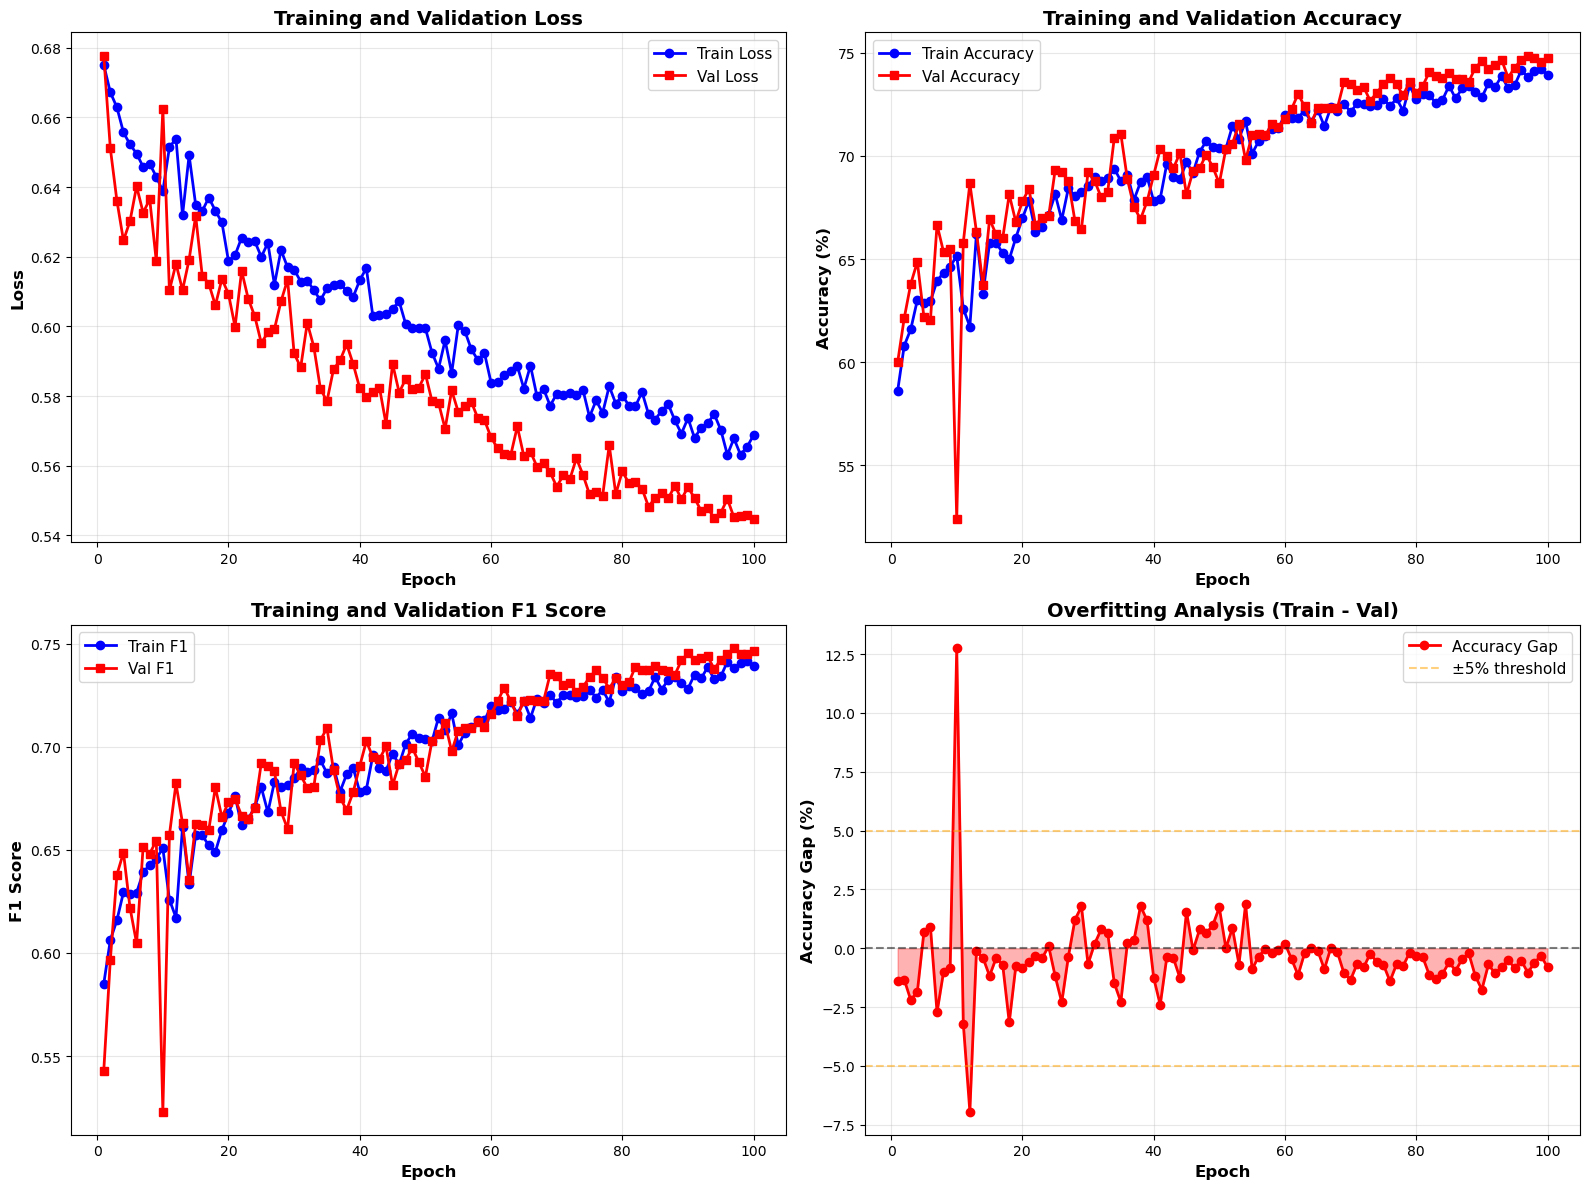

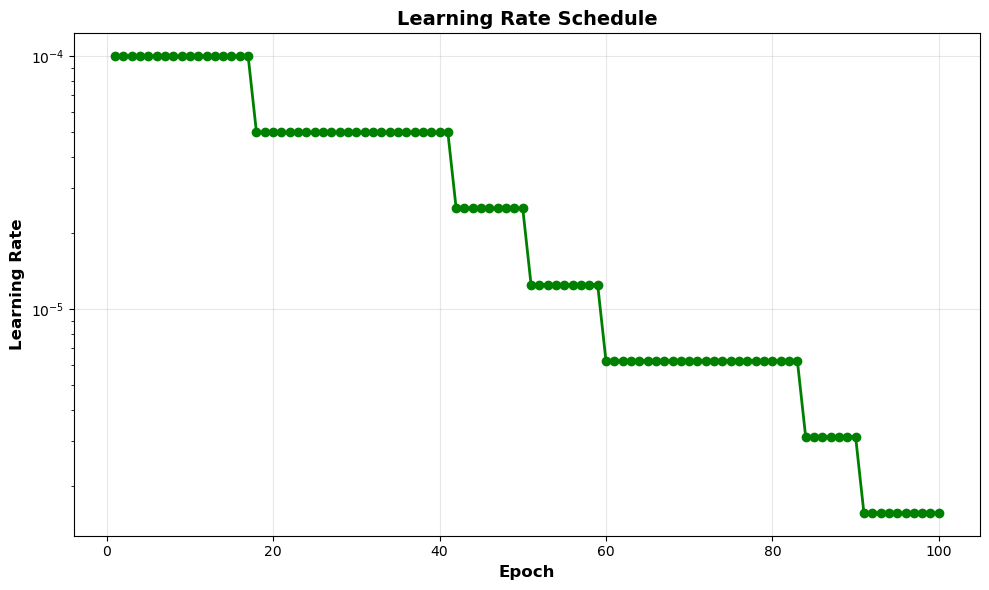

In [141]:
plot_training_history(history)


MODEL EVALUATION


Evaluating: 100%|█████████████████████████████| 188/188 [00:07<00:00, 26.51it/s]



TEST SET RESULTS
Accuracy: 75.87%
F1 Score: 0.7570
AUC-ROC: 0.8402

Classification Report:
              precision    recall  f1-score   support

Non-Violence     0.8099    0.6760    0.7369       750
    Violence     0.7220    0.8413    0.7771       750

    accuracy                         0.7587      1500
   macro avg     0.7659    0.7587    0.7570      1500
weighted avg     0.7659    0.7587    0.7570      1500



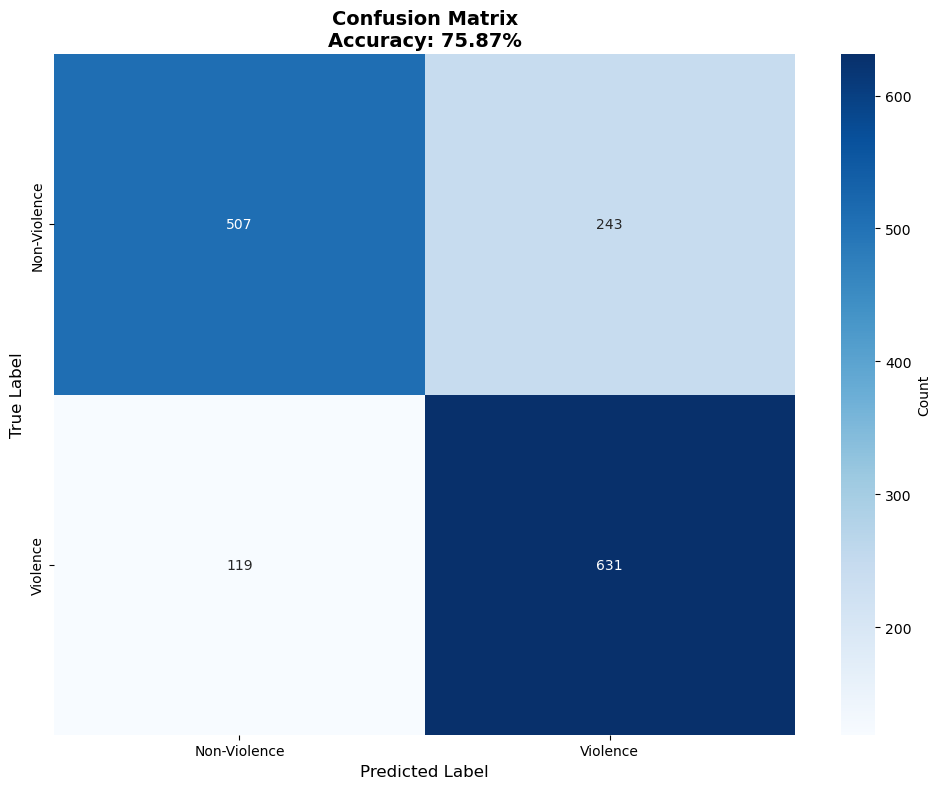

In [142]:
predictions, labels, probs = evaluate_model(model, test_loader)

In [161]:
# Instead of using config.MODEL_SAVE_PATH
model_path = 'models/gnn_yolov8n_violence_detection.pth'
save_model(model, history, model_path)


✓ GNN Model saved to: models/gnn_yolov8n_violence_detection.pth



TESTING FRAME-BY-FRAME PREDICTION (GNN MODEL)

VIDEO PREDICTION - FRAME BY FRAME (GNN MODEL)
Video: Violence_Dataset/Violence/V_253.mp4
Total Frames: 162
FPS: 30
Resolution: 442x720



Processing video: 100%|███████████████████████| 162/162 [00:03<00:00, 50.52it/s]



✓ Output video saved: output_videos/gnn_predicted_output.mp4


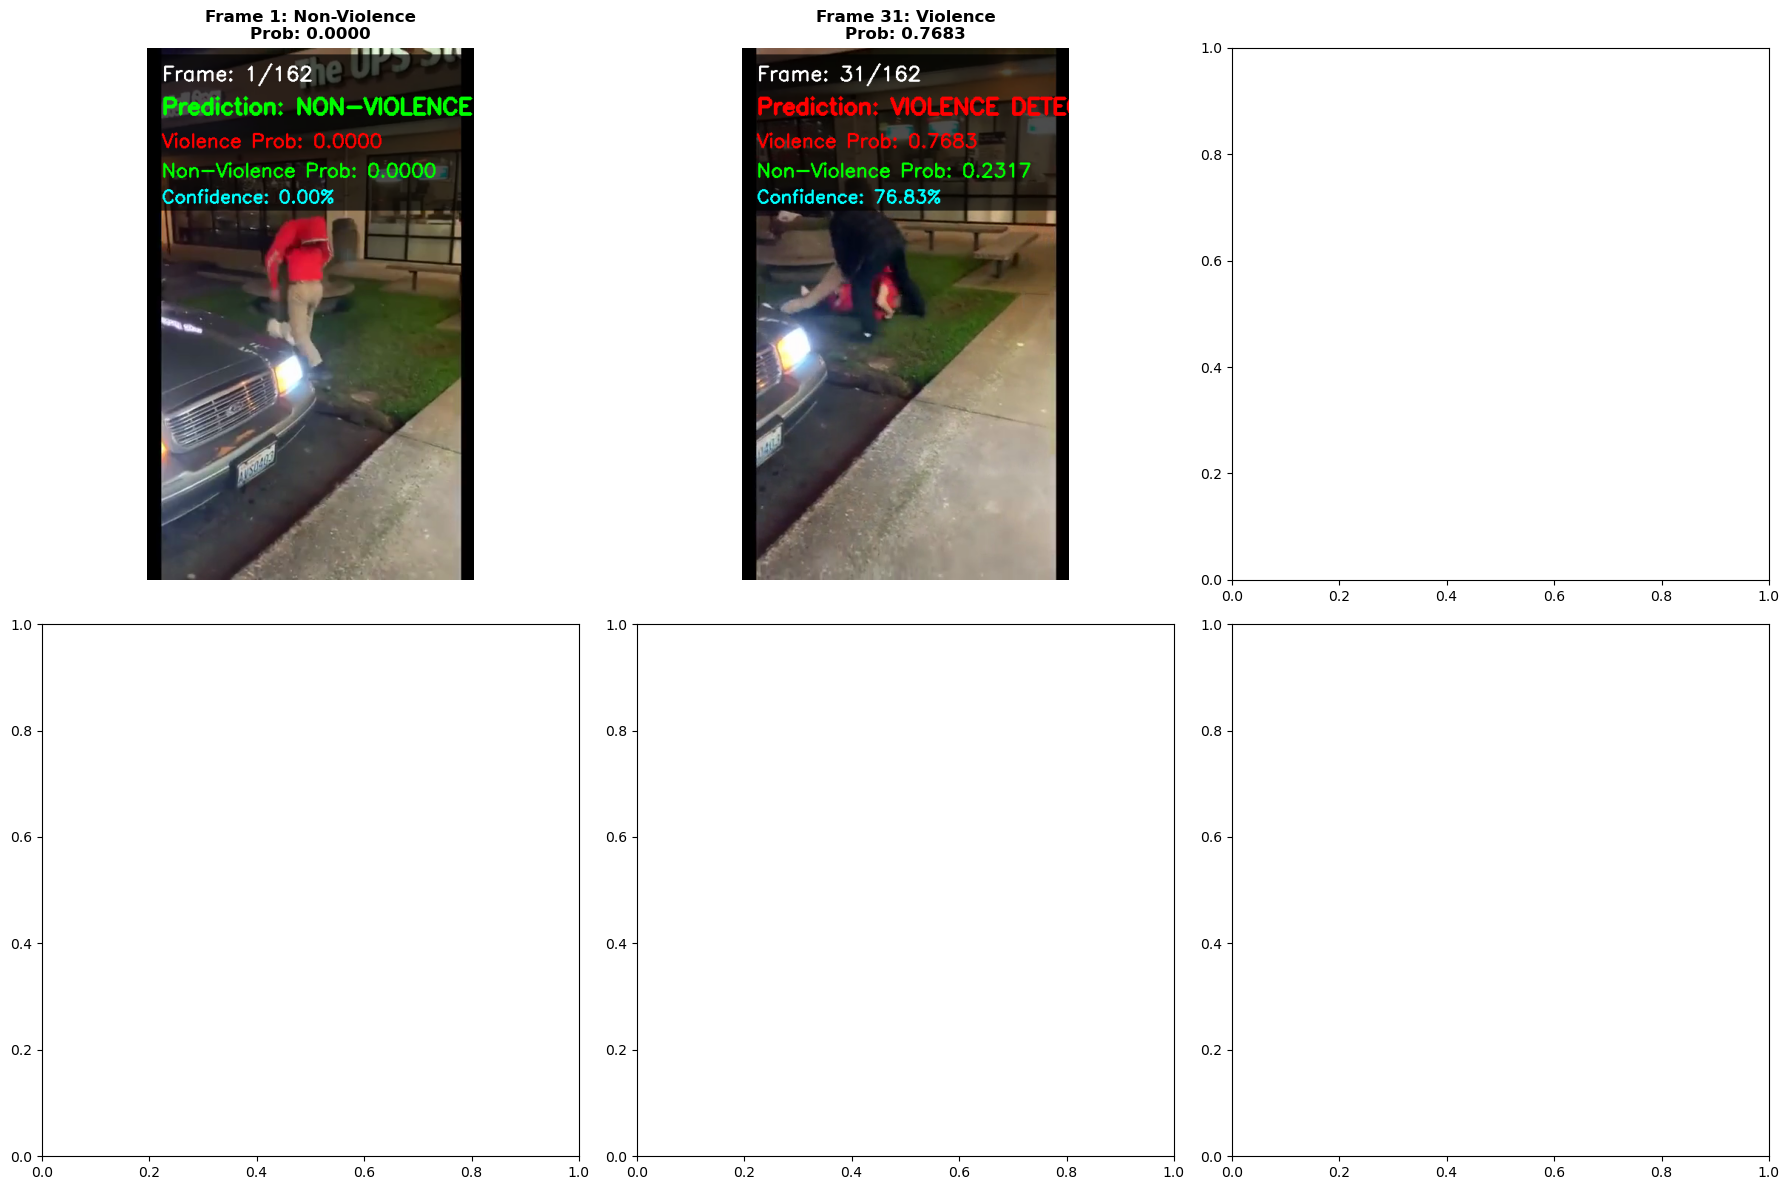

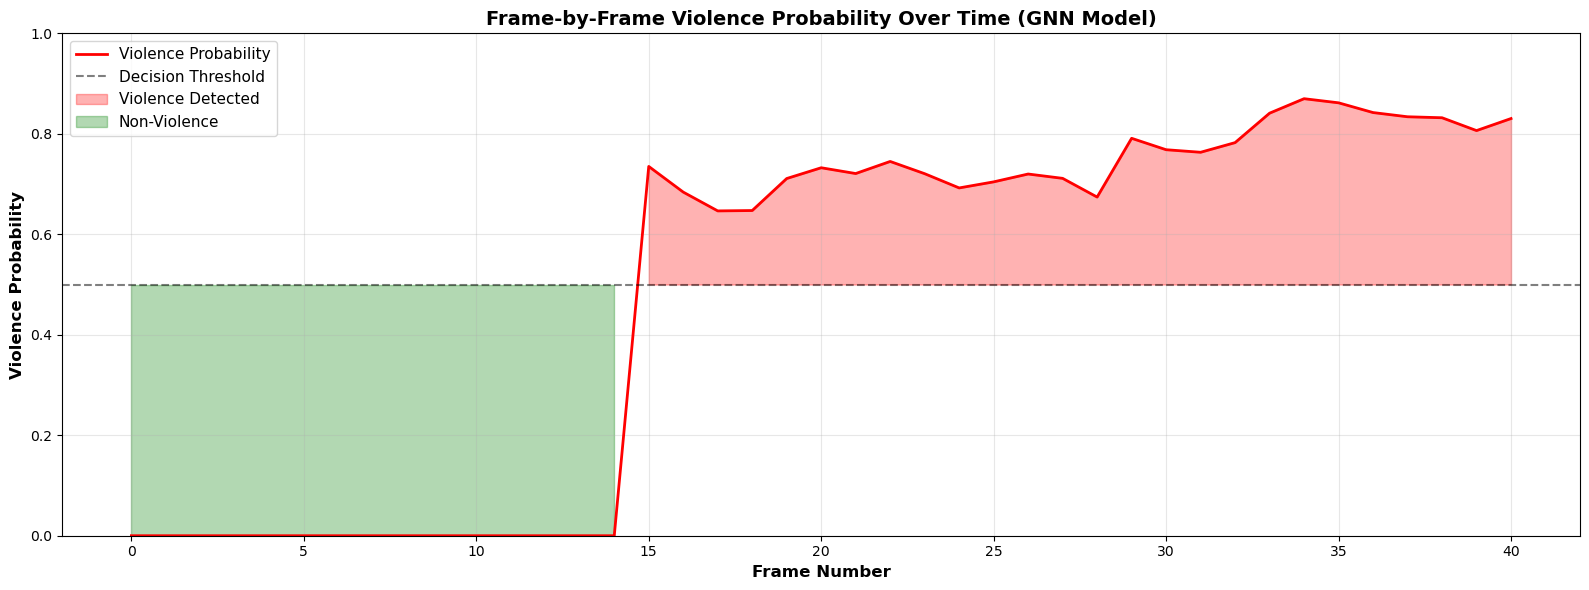


PREDICTION SUMMARY
Total Frames Processed: 41
Violence Frames: 26 (63.41%)
Non-Violence Frames: 15 (36.59%)
Maximum Violence Probability: 0.8699
Maximum Non Violence Probability: 0.3535
Overall Video Prediction: VIOLENCE


In [292]:
print("\n" + "="*70)
print("TESTING FRAME-BY-FRAME PREDICTION (GNN MODEL)")
print("="*70)

sample_videos = list(Path(config.VIOLENCE_PATH).glob('*.mp4'))
if len(sample_videos) == 0:
    sample_videos = list(Path(config.NON_VIOLENCE_PATH).glob('*.mp4'))

if len(sample_videos) > 0:
    test_video_path = str(sample_videos[0])
    output_video_path = os.path.join(config.OUTPUT_PATH, 'gnn_predicted_output.mp4')
    
    frame_results = predict_video_frame_by_frame(
        test_video_path, 
        model, 
        extractor, 
        output_path=output_video_path,
        show_frames=True
    )
else:
    print("⚠ No sample videos found for testing!")


In [320]:
def load_model(filepath):
    """Load saved GNN model"""
    # Add weights_only=False to bypass the security check
    checkpoint = torch.load(filepath, map_location=device, weights_only=False)
    
    model = GNNViolenceDetectionModel(
        yolo_dim=checkpoint['config']['yolo_dim'],
        keypoint_dim=checkpoint['config']['keypoint_dim'],
        hidden_size=checkpoint['config']['hidden_size'],
        gnn_hidden=checkpoint['config']['gnn_hidden'],
        gnn_layers=checkpoint['config']['gnn_layers'],
        lstm_layers=checkpoint['config']['lstm_layers'],
        dropout=checkpoint['config']['dropout']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, checkpoint.get('history', None)

In [326]:
v_path = 'fighting3.mp4'

def predict_new_video(v_path, model_path=None):
    """
    Complete inference pipeline for new videos with GNN
    """
    if model_path:
        model, _ = load_model(model_path)
    
    # Create output folder if it doesn't exist
    output_folder = 'output_videos_new_data'
    os.makedirs(output_folder, exist_ok=True)
    
    # Get just the filename (without path)
    video_filename = os.path.basename(v_path)
    
    # Create output path in the new folder
    output_filename = video_filename.replace('.mp4', '_gnn_predicted.mp4')
    output_path = os.path.join(output_folder, output_filename)
    
    results = predict_video_frame_by_frame(
        v_path,
        model,
        extractor,
        output_path=output_path,
        show_frames=True
    )
    
    return results

Processing video: fighting3.mp4

VIDEO PREDICTION - FRAME BY FRAME (GNN MODEL)
Video: fighting3.mp4
Total Frames: 1847
FPS: 30
Resolution: 640x352



Processing video: 100%|█████████████████████| 1847/1847 [00:35<00:00, 51.61it/s]



✓ Output video saved: output_videos_new_data/fighting3_gnn_predicted.mp4


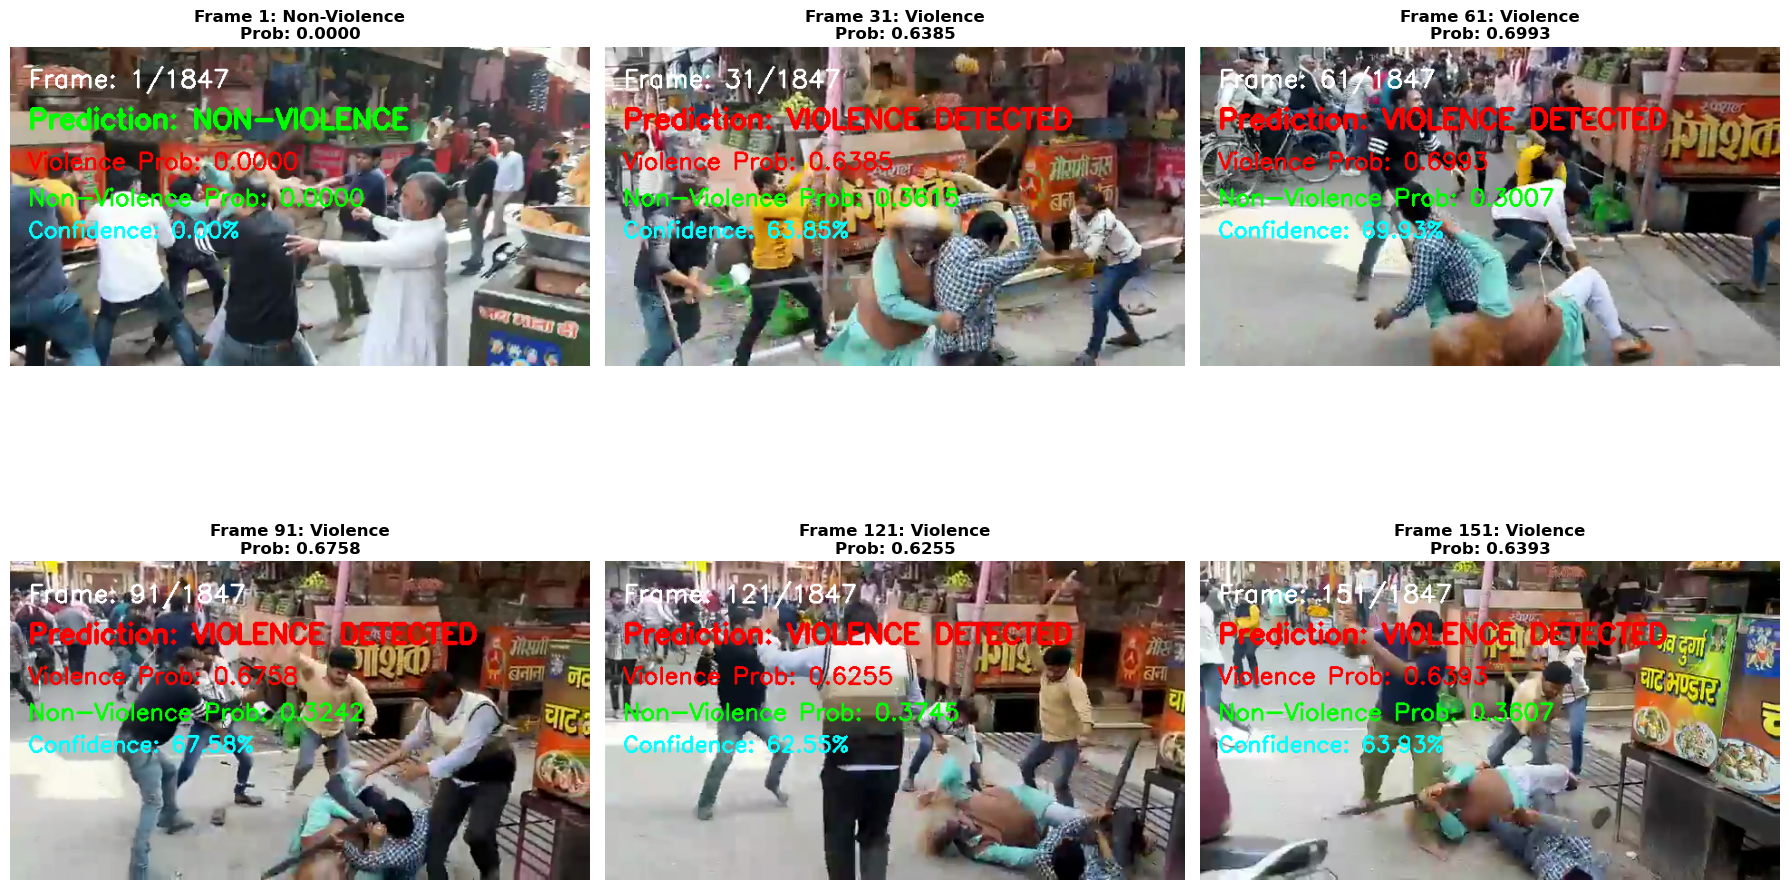

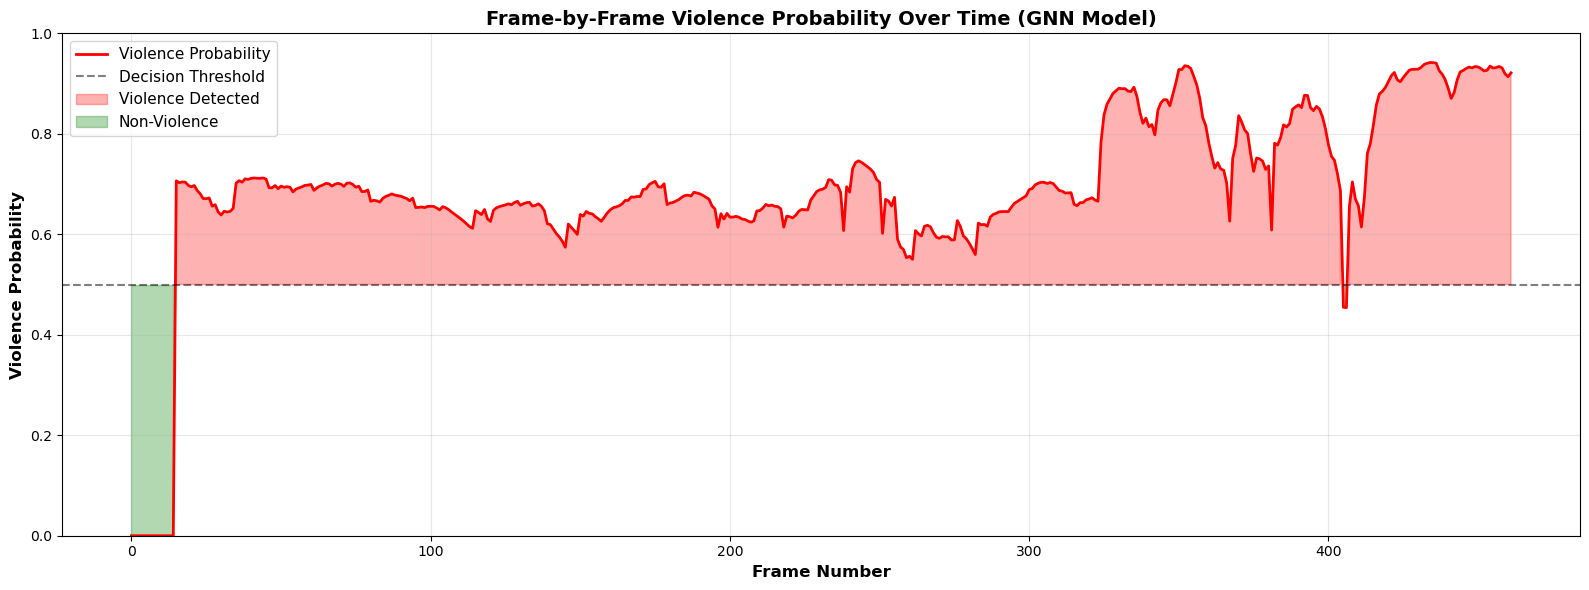


PREDICTION SUMMARY
Total Frames Processed: 462
Violence Frames: 445 (96.32%)
Non-Violence Frames: 17 (3.68%)
Maximum Violence Probability: 0.9420
Maximum Non Violence Probability: 0.5460
Overall Video Prediction: VIOLENCE

✓ Prediction complete!
✓ Output saved to: output_videos_new_data


In [328]:
# Run prediction
model_path = 'models/gnn_yolov8n_violence_detection.pth'
v_path = 'fighting3.mp4'

if os.path.exists(v_path):
    print(f"Processing video: {v_path}")
    
    results = predict_new_video(v_path, model_path)
    
    print(f"\n✓ Prediction complete!")
    print(f"✓ Output saved to: output_videos_new_data")
else:
    print(f"Error: Video {v_path} not found!")